Autoencoder is an unsupervised neural network model that uses reconstruction error to detect anomalies or outliers. The reconstruction error is the difference between the reconstructed data and the input data.

Autoencoder uses only normal data to train the model and all data to make predictions. Therefore, we expect outliers to have higher reconstruction errors because they are different from the regular data.

In this article, we will use the Python Tensorflow Keras library to illustrate the process of identifying outliers using an autoencoder. To be specific, we will cover:

- What is the algorithm behind autoencoder for anomaly detection?
- How to train an autoencoder model?
- How to set a threshold for autoencoder anomaly detection?
- How to evaluate autoencoder anomaly detection performance?


### **Step 1: Import Libraries**

In [1]:
# Synthetic dataset  
from sklearn.datasets import make_classification# Data processing  
import pandas as pd  
import numpy as np  
from collections import Counter# Visualization  
import matplotlib.pyplot as plt  
import seaborn as sns# Model and performance  
import tensorflow as tf  
from tensorflow.keras import layers, losses  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import classification_report

### **Step 2: Create Dataset With Anomalies**
Using make_classification from the sklearn library, We created two classes with the ratio between the majority class and the minority class being 0.995:0.005. 32 informative features were made as predictors. We did not include any redundant or repeated features in this dataset.



In [2]:
# Create an imbalanced dataset  
X, y = make_classification(n_samples=100000, n_features=32, n_informative=32,  
                           n_redundant=0, n_repeated=0, n_classes=2,  
                           n_clusters_per_class=1,  
                           weights=[0.995, 0.005],  
                           class_sep=0.5, random_state=0)

### **Step 3: Train Test Split**


In this step, we split the dataset into 80% training data and 20% validation data. random_state ensures that we have the same train test split every time. The seed number for random_state does not have to be 42, and it can be any number.

In [3]:
# Train test split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)# Check the number of records  
print('The number of records in the training dataset is', X_train.shape[0])  
print('The number of records in the test dataset is', X_test.shape[0])  
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 80000
The number of records in the test dataset is 20000
The training dataset has 79200 records for the majority class and 800 records for the minority class.


**Minority class data points are outliers or anomalies**

In [5]:
X_train

array([[-3.75949643e+00, -3.78605852e-01, -1.46362879e+00, ...,
         2.70382420e+00,  1.78280865e+00,  2.63419776e-01],
       [-6.32129714e+00, -2.28430570e+00, -5.14184296e-01, ...,
        -3.08761234e+00, -2.13422351e-03,  3.06975030e+00],
       [ 3.63680373e+00,  5.81323126e+00, -3.81501159e-01, ...,
        -4.08324707e+00, -1.31913802e+00,  5.24207380e+00],
       ...,
       [ 2.11795713e+00, -6.87902640e+00, -1.34571204e+00, ...,
         3.31142601e+00, -7.73686609e-02, -6.67414603e+00],
       [-1.61331210e-01, -3.23563815e+00, -4.34442763e+00, ...,
        -3.89822446e-01, -1.21105090e+00, -9.30390350e-02],
       [ 2.21867298e-01, -1.21181512e+00, -3.19728190e+00, ...,
         5.88137865e+00, -2.40009494e+00, -1.94711318e+00]])

### **Step 4: Autoencoder Algorithm For Anomaly Detection**
The autoencoder model for anomaly detection has six steps. The first three steps are for model training, and the last three steps are for model prediction.

- Step 1 is the encoder step. The essential information is extracted by a neural network model in this step.
- Step 2 is the decoder step. In this step, the model reconstructs the data using the extracted information.
- Step 3: Iterate step 1 and step 2 to adjust the model to minimize the difference between input and reconstructed output, until we get good reconstruction results for the training dataset.
- Step 4: Make predictions on a dataset that includes outliers.
- Step 5: Set up a threshold for outliers/anomalies by comparing the differences between the autoencoder model reconstruction value and the actual value.
- Step 6: Identify the data points with a difference higher than the threshold to be outliers or anomalies.


### **Step 5: Autoencoder Model Training**
The autoencoder model trains on the normal dataset, so we must first separate the expected data from the anomaly data.

Then we created the input layer, encoder layers, and decoder layers.

In the input layer, we specified the shape of the dataset. Because the modeling dataset has 32 features, the shape is 32 here.

The encoder consists of 3 layers with 16, 8, and 4 neurons, respectively. Note that the encoder requires the number of neurons to decrease with the layers. The last layer in the encoder is the size of the encoded representation, and it is also called the bottleneck.

The decoder consists of 3 layers with 8, 16, and 32 neurons, respectively. Opposite the encoder, the decoder requires the number of neurons to increase with the layers. The output layer in the decoder has the same size as the input layer.

The `relu` the activation function is used for each layer except for the decoder output layer. `relu` is a popular activation function, but you can try other activation functions and compare the model performance.

After defining the input, encoder, and decoder layers, we create the autoencoder model to combine the layers.



In [6]:
# Keep only the normal data for the training dataset  
X_train_normal = X_train[np.where(y_train == 0)]# Input layer  
input = tf.keras.layers.Input(shape=(32,))# Encoder layers  
encoder = tf.keras.Sequential([  
  layers.Dense(16, activation='relu'),  
  layers.Dense(8, activation='relu'),  
  layers.Dense(4, activation='relu')])(input)# Decoder layers  
decoder = tf.keras.Sequential([  
      layers.Dense(8, activation="relu"),  
      layers.Dense(16, activation="relu"),  
      layers.Dense(32, activation="sigmoid")])(encoder)# Create the autoencoder  
autoencoder = tf.keras.Model(inputs=input, outputs=decoder)

After defining the input, encoder, and decoder layers, we create the autoencoder model to combine the layers.

After creating the autoencoder model, we compile the model with the optimizer of `adam` and the loss of `mae` (Mean Absolute Error).

When fitting the autoencoder model, we can see that the input and output datasets are the same, which is the dataset that contains only the normal data points.

The validation data is the testing dataset that contains both normal and anomaly data points.

The `epochs` of 20 and `batch_size` of 64 mean the model uses 64 datapoints to update the weights in each iteration, and the model will go through the whole training dataset 20 times.

`shuffle=True` will shuffle the dataset before each epoch.



In [7]:
# Compile the autoencoder  
autoencoder.compile(optimizer='adam', loss='mae')# Fit the autoencoder  
history = autoencoder.fit(X_train_normal, X_train_normal,   
          epochs=20,   
          batch_size=64,  
          validation_data=(X_test, X_test),  
          shuffle=True)

Epoch 1/20
1238/1238 [==============================] - 4s 2ms/step - loss: 2.5342 - val_loss: 2.5039
Epoch 2/20
1238/1238 [==============================] - 2s 2ms/step - loss: 2.4911 - val_loss: 2.4869
Epoch 3/20
1238/1238 [==============================] - 2s 2ms/step - loss: 2.4792 - val_loss: 2.4808
Epoch 4/20
1238/1238 [==============================] - 3s 2ms/step - loss: 2.4736 - val_loss: 2.4761
Epoch 5/20
1238/1238 [==============================] - 2s 2ms/step - loss: 2.4695 - val_loss: 2.4724
Epoch 6/20
1238/1238 [==============================] - 2s 2ms/step - loss: 2.4671 - val_loss: 2.4712
Epoch 7/20
1238/1238 [==============================] - 3s 2ms/step - loss: 2.4656 - val_loss: 2.4692
Epoch 8/20
1238/1238 [==============================] - 2s 2ms/step - loss: 2.4646 - val_loss: 2.4687
Epoch 9/20
1238/1238 [==============================] - 3s 2ms/step - loss: 2.4637 - val_loss: 2.4672
Epoch 10/20
1238/1238 [==============================] - 2s 2ms/step - loss: 2.462

This chart visualizes the training and validation loss changes during the model fitting. The x-axis is the number of epochs, and the y-axis is the loss. We can see that both training and validation losses decrease with the increase of epochs.



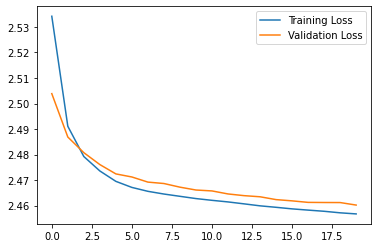

In [8]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

### **Step 6: Autoencoder Anomaly Detection Threshold**
Now that we have an autoencoder model, let’s use it to predict the outliers.

Firstly, we use `.predict` to get the reconstruction value for the testing data set containing the usual data points and the outliers.

Then we calculate the loss value between actual and reconstruction using mean absolute error.

After that, a threshold is set to identify the outliers. This threshold can be based on percentile, standard deviation, or other methods. We use 98% loss as the threshold to identify 2% of the data as outliers in this example.



The prediction loss threshold for 2% of outliers is 3.44


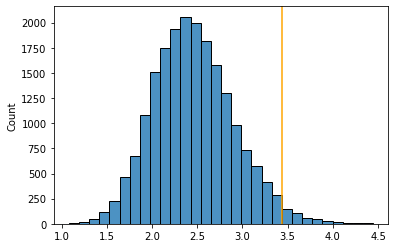

In [9]:
# Predict anomalies/outliers in the training dataset  
prediction = autoencoder.predict(X_test)# Get the mean absolute error between actual and reconstruction/prediction  
prediction_loss = tf.keras.losses.mae(prediction, X_test)# Check the prediction loss threshold for 2% of outliers  
loss_threshold = np.percentile(prediction_loss, 98)  
print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')# Visualize the threshold  
sns.histplot(prediction_loss, bins=30, alpha=0.8)  
plt.axvline(x=loss_threshold, color='orange')

The visualization chart shows that the prediction loss is close to a normal distribution with a mean of around 2.5. The prediction loss threshold for 2% of outliers is about 3.5.



### **Step 7: Autoencoder Anomaly Detection Performance**
Sometimes the dataset has the ground truth label for the anomalies, and the dataset often does not. When there is a label for anomalies, we can evaluate the model performance.

Based on the threshold we identified in the previous step, we predicted normal data points if the prediction loss is less than the threshold. Otherwise, we predict the data point to be an outlier or anomaly. We label the normal prediction 0 and outlier prediction 1 to be consistent with the ground truth label.

In [10]:
# Check the model performance at 2% threshold  
threshold_prediction = [0 if i < loss_threshold else 1 for i in prediction_loss]# # Check the prediction performance  
print(classification_report(y_test, threshold_prediction))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     19803
           1       0.01      0.01      0.01       197

    accuracy                           0.97     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.98      0.97      0.98     20000



The recall value of 0.01 shows that around 1% of the outliers were captured by the autoencoder.

